# Create ratemaps 
Jump to the bottom of the notebook for the generation of rate maps

In [ ]:
%load_ext autoreload
%autoreload 2

In [61]:
import os
import expipe
import pathlib
import numpy as np
import place_stimulation as ps
import neo
import quantities as pq
import matplotlib.pylab as plt

par = {'speed_filter': 0.3, # m/s
       'pos_fs': 60 ,
       'f_cut': 1,
       'spat_binsize': 0.02 ,
       'spat_smoothing': 0.025,
       'grid_stepsize': 0.1 ,
       'box_xlen': 1 ,
       'box_ylen': 1 ,
       'spike_size': 10,
       'field_max_wall_extent':0.1,
       'field_min_bins':12
}

# Load project in python using expipe

In [2]:
project_path = "/home/alessiob/Documents/Codes/expipe/projects/testing"

project = expipe.get_project(project_path)
actions = project.actions

In [3]:
actions

In [4]:
action = actions['1806-031218-3']

In [5]:
data_path = ps.get_data_path(action)
print(data_path)

/home/alessiob/Documents/Codes/expipe/projects/testing
actions/1806-031218-3/data/main.exdir
/home/alessiob/Documents/Codes/expipe/projects/testing/actions/1806-031218-3/data/main.exdir


In [ ]:
# For Intan recording and Open Ephys tracking clip spiketrains, epochs (stimulation triggers) using:
# - digital input evet used for sync in intan (available in main.exdir/epochs/intan-events/digital-in-0 (or 1))
# and Open Ephys tracking using:
# - sync event form open-ephys (available in main.exdir/epochs/open-ephys-events/sync_...)

In [6]:
sptr = ps.load_spiketrains(data_path, 0)

In [59]:
x, y, t, speed = ps.load_tracking(data_path, par)

Removed 24.10 % invalid measurements in path


In [9]:
epochs = ps.load_epochs(data_path)

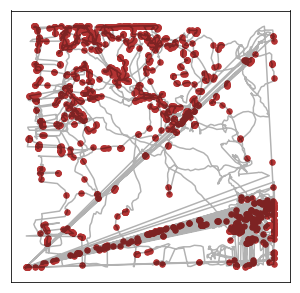

In [60]:
ps.plot_path(x, y, t, sptr[0])

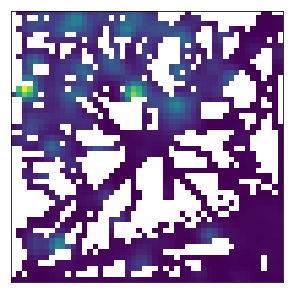

In [12]:
ps.plot_rate_map(x, y, t, sptr[0])

In [18]:
# create fake epochs
epc = neo.Epoch(times=np.arange(0, 10, 20)*pq.s, durations=[10, 5, 7]*pq.ms, 
                labels=np.array(['btn0', 'btn1', 'btn2'], dtype='S'))

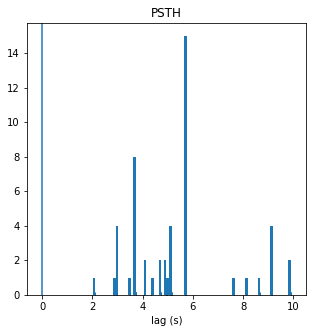

In [27]:
ps.plot_psth(sptr[0], epc, bin_size=0.1 * pq.s)

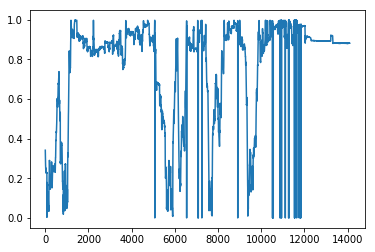

In [62]:
plt.plot(x)